0.000000 0.000000 1.999951
0.000000 0.000090 0.999951
0.000000 0.518565 0.990136
0.000015 0.518565 0.990136
0.000015 0.547604 0.989378
0.000029 0.547604 0.989375
0.000029 0.552009 0.989250
0.000044 0.552009 0.989248
0.000044 0.570979 0.988750
0.000059 0.570979 0.988749
0.000059 0.576193 0.988592
0.000073 0.576193 0.988590
0.000073 0.594983 0.988080
0.000088 0.594983 0.988078
0.000088 0.596781 0.988026
0.000103 0.596781 0.988022
0.000103 0.607210 0.987664
0.000117 0.607210 0.987663
0.000117 0.613414 0.987435
0.000132 0.613414 0.987430
0.000132 0.623573 0.987125
0.000147 0.623573 0.987125
0.000147 0.628428 0.986964
0.000161 0.628428 0.986963
0.000161 0.637328 0.986674
0.000176 0.637328 0.986671
0.000176 0.637778 0.986658
0.000191 0.637778 0.986658
0.000191 0.642183 0.986514
0.000205 0.642183 0.986511
0.000205 0.643082 0.986459
0.000220 0.643082 0.986454
0.000220 0.645240 0.986394
0.000235 0.645240 0.986393
0.000235 0.650454 0.986208
0.000249 0.650454 0.986207
0.000249 0.664119 0.985722
0

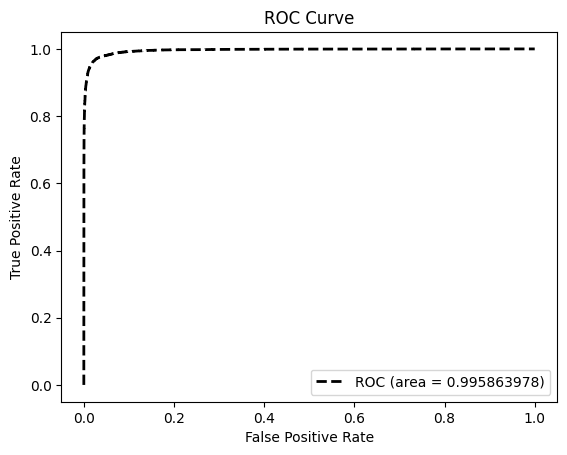

In [5]:
import pickle
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_pkl_seq_one_by_img(file_name, seq):
    with open(file_name, 'rb') as f:
        out_all = pickle.load(f)
    out_all_seq_one = list(filter(lambda x: int(
        (x['img_info']['file_name']).split('/')[-2]) == seq, out_all))
    min_img_id = out_all_seq_one[0]['img_info']['image_id']
    max_img_id = out_all_seq_one[-1]['img_info']['image_id']
    out_all_by_img = {}
    for img_id in range(min_img_id, max_img_id+1):
        out_all_img_one = list(
            filter(lambda x: x['img_info']['image_id'] == img_id, out_all_seq_one))
        out_all_by_img[img_id] = out_all_img_one
    return out_all_by_img


def get_feat_del_nan_per_img(img_content):
    track_id_np = np.array([x["track_id"] for x in img_content])
    # below get reid feat only.
    reid_feat_np = np.array([x["reid_feat"] for x in img_content])
    # below del nan.
    no_nan_id = np.unique(np.where(~np.isnan(reid_feat_np))[0])
    reid_feat_np_no_nan = reid_feat_np[no_nan_id, :]
    track_id_np_no_nan = track_id_np[no_nan_id]
    return track_id_np_no_nan, reid_feat_np_no_nan


def reid_track_eval_two_frame(cur_img_content, next_img_content):
    cur_track_id, cur_reid_feat = get_feat_del_nan_per_img(cur_img_content)
    next_track_id, next_reid_feat = get_feat_del_nan_per_img(next_img_content)
    dist_mat = cdist(cur_reid_feat, next_reid_feat, metric='cosine')
    label_mat = cdist(np.expand_dims(cur_track_id, axis=1), np.expand_dims(
        next_track_id, axis=1), metric='cityblock')
    # change cos distance to cos similarity.
    sim_flatten = 1-dist_mat.flatten()
    # below change [-1,1] of cos dist to [0,1].
    prob_flatten = (sim_flatten+1)/2
    assert np.all(prob_flatten>=0) and np.all(prob_flatten<=1),"prob must be in [0,1]."
    label_flatten = [1 if x == 0 else 0 for x in label_mat.flatten()]
    return prob_flatten, label_flatten


def reid_eval_by_seq(content_by_img):
    prob_seq_one = []
    label_seq_one = []
    for cur_img_id, cur_img_content in content_by_img.items():
        next_img_id = cur_img_id+1
        if next_img_id not in content_by_img.keys()  \
                or len(cur_img_content) == 0 or len(content_by_img[next_img_id]) == 0:
            # cur_img could be the last img, or some imgs don't have gt_box.
            continue
        next_img_content = content_by_img[next_img_id]
        prob_pair_one, label_pair_one = reid_track_eval_two_frame(
            cur_img_content, next_img_content)
        prob_seq_one.extend(prob_pair_one)
        label_seq_one.extend(label_pair_one)
    return prob_seq_one,label_seq_one

if __name__ == '__main__':
    val_list = [2, 6, 7, 8, 10, 13, 14, 16, 18]
    framelink_8 = "../../training_dir_hddb/reid_framelink/reid_one_class_infer_right_track_reid_eval_in_train/COCO_pretrain_strong/search_for_loss_combination/seq_shuffle_fl_8_lr_0_005_bs_8_eval_500/BoxInst_MS_R_50_1x_kitti_mots/reid_infer_and_eval_out/iter_0006999/reid_eval_out.pkl"
    framelink_2 = '../../training_dir_hddb/reid_framelink/reid_one_class_infer_right_track_reid_eval_in_train/COCO_pretrain_strong/search_for_loss_combination/seq_shuffle_fl_2_lr_0_005_bs_8_eval_500/BoxInst_MS_R_50_1x_kitti_mots/reid_infer_and_eval_out/iter_0006999/reid_eval_out.pkl'
    file_name = framelink_8
    prob_seq_all = []
    label_seq_all = []
    for seq_one in val_list:
        out_all_by_img = get_pkl_seq_one_by_img(file_name, seq=seq_one)
        prob_seq_one,label_seq_one = reid_eval_by_seq(out_all_by_img)
        prob_seq_all.extend(prob_seq_one)
        label_seq_all.extend(label_seq_one)
    # y_label = ([1, 1, 1, 2, 2, 2])  # 非二进制需要pos_label
    # y_pre = ([0.3, 0.5, 0.9, 0.8, 0.4, 0.6])
    fpr, tpr, thersholds = roc_curve(label_seq_all, prob_seq_all)
    
    for i, value in enumerate(thersholds):
        print("%f %f %f" % (fpr[i], tpr[i], value))
    
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.9f})'.format(roc_auc), lw=2)
    
    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()